In [23]:
import xarray as xr
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import numpy as np
import geopandas as gpd
import pandas as pd
import sys
sys.path.append("/home/adam/cloud/gdrive/FATES/Earth-System-Model-Tools/process_output/")
import esm_tools
import importlib
importlib.reload(esm_tools)
from matplotlib.colors import LinearSegmentedColormap
from rasterio.transform import from_origin
import rasterio

In [18]:
def create_mapping_vars(ds):
    
    # Basal area
    ba_pft = esm_tools.get_pft_level_basal_area(ds,dbh_min=10,return_xarray=True)
    ba_pine = ba_pft.isel(fates_levpft = 0)
    ba_cedar = ba_pft.isel(fates_levpft = 1)
    ba_fir = ba_pft.isel(fates_levpft = 2)
    ba_conifer = ba_pft.sel(fates_levpft = slice(0,3)).sum(dim = "fates_levpft")
    ba_oak = ba_pft.isel(fates_levpft = 4)
    ba_shrub = ba_pft.isel(fates_levpft = 3)
    ba_tree = ba_pft.sum(dim = "fates_levpft") - ba_shrub
    
    
    # Frac of total tree basal area
    fba_pine = ba_pine / ba_tree
    fba_cedar = ba_cedar / ba_tree
    fba_fir = ba_fir / ba_tree
    fba_oak = ba_oak / ba_tree
    fba_conifer = ba_conifer / ba_tree
    
    # Cover
    shrub_cov = esm_tools.get_pft_level_crown_area(ds,pft_index = 3,
                                                   canopy_area_only = False, return_xarray=True)
    shrub_cov_canopy = esm_tools.get_pft_level_crown_area(ds,pft_index = 3,
                                                          canopy_area_only = True, return_xarray=True)
    pine_cov_canopy = esm_tools.get_pft_level_crown_area(ds,pft_index = 0,
                                                          canopy_area_only = True, return_xarray=True)
    cedar_cov_canopy = esm_tools.get_pft_level_crown_area(ds,pft_index = 1,
                                                          canopy_area_only = True, return_xarray=True)
    fir_cov_canopy = esm_tools.get_pft_level_crown_area(ds,pft_index = 2,
                                                          canopy_area_only = True, return_xarray=True)
    oak_cov_canopy = esm_tools.get_pft_level_crown_area(ds,pft_index = 4,
                                                          canopy_area_only = True, return_xarray=True)
    
    conifer_cov_canopy = pine_cov_canopy + cedar_cov_canopy + fir_cov_canopy
    #total_npp = esm_tools.get_total_npp(ds)
    
    TBOT = ds['TBOT']
    
    
    return [ba_conifer, ba_oak, ba_cedar, ba_pine, ba_fir,#BA
            fba_pine, fba_cedar, fba_fir, fba_oak, fba_conifer,#fba
            shrub_cov_canopy, oak_cov_canopy, conifer_cov_canopy,TBOT] #cover

def make_spatial_geodataframe_of_output_data(mask_file,data_arrays,
                                             data_names = ['ba_conifer', 'ba_oak', 'ba_cedar', 'ba_pine', 'ba_fir',
                                                           'fba_pine', 'fba_cedar', 'fba_fir', 'fba_oak', 'fba_conifer',
                                                           'shrub_cov_canopy',
                                                           'oak_cov_canopy','conifer_cov_canopy','TBOT']):

    
    shape_2D = data_arrays[0].shape
    shape_1D = shape_2D[0] * shape_2D[1]
    
    data_arrays_1D = [data_array.values.reshape(shape_1D) for data_array in data_arrays]
    
    # Get boolean array of the elements in the unstructured mask to map
    coords_in = [el == 0 for el in mask_file['elementMask'].values]

    # Use boolean array to filter to points we want to map
    data_arrays_1D_masked = [data_array_1D[coords_in] for data_array_1D in data_arrays_1D]
    
    # Get the coordinates of the cells we want to map
    #mask_file['centerCoords'].values[coords_in,:]
    mask_lon = mask_file['centerCoords'].values[coords_in,0]
    mask_lat = mask_file['centerCoords'].values[coords_in,1]

    if len(data_arrays_1D_masked[0]) != len(mask_lat):
        print("Error")
        return
    
    # Make spatial points object of the points and data to map
    mask_points = gpd.points_from_xy(mask_lon, mask_lat, z=None, crs="EPSG:4326")
    
    
    my_dict = {}
    for i,data_name in enumerate(data_names):
         my_dict[data_name] = data_arrays_1D_masked[i]
        
    df = pd.DataFrame(my_dict)

    geo_df = gpd.GeoDataFrame(df, geometry=mask_points)
    return geo_df



def points_to_raster(gdf, cell_size=1, attribute_column=None):
    """
    Convert a GeoDataFrame of points to a raster.

    Parameters:
    gdf (GeoDataFrame): A GeoDataFrame containing point geometries.
    cell_size (float): The cell size of the raster. The units should match the CRS of the GeoDataFrame.

    Returns:
    tuple: A tuple containing the raster (numpy array) and its transformation.
    """
    # Ensure the GeoDataFrame contains points
    if not all(gdf.geometry.type == 'Point'):
        raise ValueError("GeoDataFrame must contain only Point geometries")

    # Get the bounds of the GeoDataFrame
    minx, miny, maxx, maxy = gdf.total_bounds
    width = int((maxx - minx) / cell_size)
    height = int((maxy - miny) / cell_size)

    # Create an empty raster array
    raster = np.zeros((height, width))

    # Define the raster transformation
    transform = from_origin(minx, maxy, cell_size, cell_size)

    # Function to convert geographic coordinates to raster indices
    def coords_to_pixel(x, y, transform):
        col, row = ~transform * (x, y)
        return int(row), int(col)

    # Burn the points into the raster
    for _, row in gdf.iterrows():
        x, y = row.geometry.x, row.geometry.y
        row_idx, col_idx = coords_to_pixel(x, y, transform)
        if 0 <= row_idx < height and 0 <= col_idx < width:
            raster[row_idx, col_idx] = row[attribute_column] if attribute_column else 1

    return raster, transform


## Import data

In [19]:
import math
def dist(y2,y1,x2,x1):
    dist = math.sqrt( (y2-y1)**2 + (x2-x2)**2 )
    return dist

pointdist = dist(-118.9468,-119.0320,37.3360,37.2830)

In [20]:
path_to_ca = '/home/adam/cloud/gdrive/fire_project/local_data/ca-state-boundary/CA_State_TIGER2016.shp'
mask_ahb = xr.open_dataset('CZ_mask_111623.nc')
fates_output = xr.open_dataset('sierra-CZ-0009-112823_CLM_FATES.clm2.h0.1819-12.nc')

## Create variables to map

In [21]:
data_to_map = create_mapping_vars(fates_output)
geo_df = make_spatial_geodataframe_of_output_data(mask_ahb,data_to_map)
geo_df

,ba_conifer,ba_oak,ba_cedar,ba_pine,ba_fir,fba_pine,fba_cedar,fba_fir,fba_oak,fba_conifer,shrub_cov_canopy,oak_cov_canopy,conifer_cov_canopy,TBOT,geometry
0,0.046504,0.000000,0.044846,0.000000,0.001658,0.000000,0.964355,0.035646,0.000000,1.000000,0.379197,0.004005,0.010867,282.904877,POINT (-119.38524 36.67720)
1,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.288345,0.000130,0.000408,282.905609,POINT (-119.30090 36.72509)
2,0.086082,0.000000,0.078331,0.000000,0.007751,0.000000,0.909954,0.090046,0.000000,1.000000,0.478349,0.006503,0.012078,282.778076,POINT (-119.44505 36.74478)
3,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.230688,0.011240,0.004827,282.712524,POINT (-119.36067 36.79272)
4,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.083873,0.002340,0.001111,282.318451,POINT (-119.27618 36.84060)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.372947,0.007983,0.344759,0.003226,0.024962,0.008468,0.905045,0.065530,0.020957,0.979043,0.353744,0.041564,0.022476,274.295197,POINT (-119.52779 37.41011)
67,9.993171,4.422740,9.847364,0.090356,0.055451,0.006268,0.683090,0.003846,0.306796,0.693204,0.002668,0.413167,0.241345,272.502869,POINT (-119.44260 37.45819)
68,5.723754,5.794111,5.582150,0.052414,0.089191,0.004551,0.484651,0.007744,0.503054,0.496946,0.001350,0.732247,0.127409,271.580872,POINT (-119.35727 37.50623)
69,5.593120,11.511870,5.568868,0.002579,0.021673,0.000151,0.325570,0.001267,0.673012,0.326988,0.000921,0.785182,0.091661,270.477814,POINT (-119.27182 37.55419)


In [24]:
variable_names = ['ba_conifer', 'ba_oak','ba_cedar', 'ba_pine', 'ba_fir','fba_pine', 'fba_cedar',
                  'fba_fir', 'fba_oak', 'fba_conifer','shrub_cov_canopy',
                  'oak_cov_canopy','conifer_cov_canopy','TBOT']

for variable_name in variable_names:

    raster, transform = points_to_raster(geo_df, cell_size=pointdist,attribute_column=variable_name)

    # Save the raster
    with rasterio.open('raster_output_0009_1819/' + variable_name + '.tif', 'w', driver='GTiff',
                       height=raster.shape[0],
                       width=raster.shape[1],
                       count=1, dtype=str(raster.dtype),
                       crs=geo_df.crs.to_string(),
                       transform=transform) as dst:
        dst.write(raster, 1)

In [29]:

import geopandas as gpd
import requests
from rasterio.io import MemoryFile

def download_dem(gdf, dem_source_url):
    """
    Download DEM data for the bounding box of a GeoDataFrame.

    :param gdf: GeoDataFrame containing the area of interest.
    :param dem_source_url: The template URL for the DEM data source.
    :return: A Rasterio dataset.
    """

    # Get the bounding box of the GeoDataFrame
    bbox = gdf.total_bounds  # returns (minx, miny, maxx, maxy)
    
    # Format the DEM source URL with the bounding box
    url = dem_source_url.format(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])

    # Send a request to the DEM source
    response = requests.get(url)
    response.raise_for_status()  # will raise an error if the download failed

    # Open the DEM data as a Rasterio dataset
    with MemoryFile(response.content) as memfile:
        with memfile.open() as dataset:
            return dataset

# Example usage
#gdf = gpd.read_file('path_to_your_shapefile.shp')
dem_source_url = 'https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&west={minx}&south={miny}&east={maxx}&north={maxy}&outputFormat=GTiff'
dem_dataset = download_dem(geo_df, dem_source_url)

# Now you can use dem_dataset for further processing


HTTPError: 401 Client Error: 401 for url: https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&west=-119.83047485351562&south=36.67720413208008&east=-118.80032348632812&north=37.60207748413086&outputFormat=GTiff

In [58]:
# import geopandas as gpd
# import matplotlib.pyplot as plt


# def plot_geodataframe_with_custom_colormap(gdf, variable_name, cmap_range=None, cmap_colors=None):
#     """
#     Plot a GeoDataFrame with a custom colormap based on a variable.
    
#     Args:
#         gdf (geopandas.GeoDataFrame): The GeoDataFrame containing the data.
#         variable_name (str): The name of the variable to be mapped.
#         cmap_range (tuple, optional): The range of values for the colormap. Default is None, which
#             will use the minimum and maximum values in the data.
#         cmap_colors (list, optional): List of colors for the colormap. Default is None, which
#             will use a default light-to-dark green colormap.
#     """
#     # Create a copy of the GeoDataFrame to avoid modifying the original data
#     gdf_copy = gdf.copy()
    
#     # If cmap_range is not provided, use the minimum and maximum values of the variable
#     if cmap_range is None:
#         cmap_range = (gdf_copy[variable_name].min(), gdf_copy[variable_name].max())
    
#     # If cmap_colors is not provided, use a default light-to-dark green colormap
#     if cmap_colors is None:
#         cmap_colors = ['#a1d99b', '#006d2c']
    
#     # Create a colormap
#     cmap = LinearSegmentedColormap.from_list('custom_colormap', cmap_colors, N=256)
    
#     # Normalize the variable values to the range [0, 1]
#     gdf_copy['normalized_values'] = (gdf_copy[variable_name] - cmap_range[0]) / (cmap_range[1] - cmap_range[0])
    
#     # Plot the GeoDataFrame with colored points
#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     gdf_copy.plot(column=variable_name, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    
#     # Customize the legend
# #     legend = ax.get_legend()
# #     legend.set_title(variable_name)
# #     legend.set_bbox_to_anchor((1, 1))
    
#      # Customize the legend
#     legend = ax.get_legend()
#     if legend is not None:  # Check if legend exists
#         legend.set_title(variable_name)
#         legend.set_bbox_to_anchor((1, 1))
    
#     # Show the map
#     plt.axis('off')
#     plt.title(f'Map of {variable_name}')
#     plt.show()



/home/adam/miniconda3/envs/la-veg/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


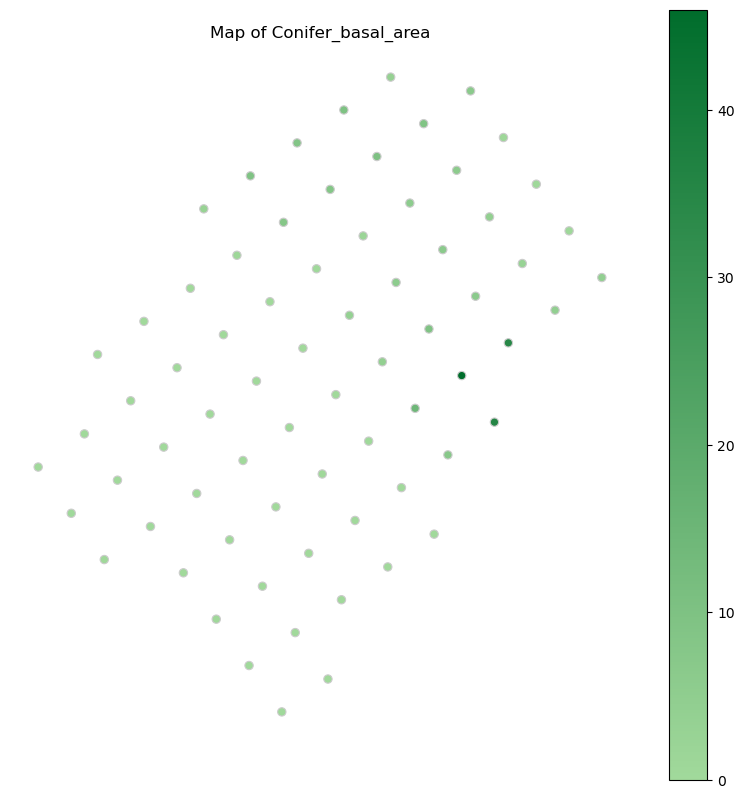

In [59]:
plot_geodataframe_with_custom_colormap(geo_df_0009,"Conifer_basal_area")

In [60]:
geo_df_0009.to_file('member_0009_structure.shp')

/tmp/ipykernel_12298/990017464.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_df_0009.to_file('member_0009_structure.shp')


In [28]:
data_names = ["Conifer_basal_area",
                                                                                "Oak_basal_area",
                                                                                "Shrub_cover",
                                                                                "Shrub_cover_canopy"]

In [32]:

    
my_dict.keys()

dict_keys(['Conifer_basal_area', 'Oak_basal_area', 'Shrub_cover', 'Shrub_cover_canopy'])

In [49]:
mask_gdf_biomass.to_file('mask_gdf_biomass.shp')

In [30]:
mask_ahb['centerCoords'].values[0,:]

array([-120.85491943,   28.62024307])

In [19]:
np.where(biomass_ahb.values[0,:,:] > 0.01)

(array([71, 71, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74,
        74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
        75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77,
        77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79,
        79, 79, 79]),
 array([70, 71, 70, 71, 72, 73, 74, 70, 71, 72, 73, 74, 75, 76, 70, 71, 72,
        73, 74, 75, 76, 77, 78, 79, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 69, 70, 71, 72, 73,
        74, 75, 76, 77, 78, 79, 71, 72, 73, 74, 75, 76, 77, 78, 79, 74, 75,
        76, 77, 78]))

In [45]:
biomass_flat = biomass_ahb.values[0].reshape(151*147)[coords_in]
len(biomass_flat)


71

In [53]:
biomass.isel(lat = 71, lon = 70)

<xarray.DataArray 'FATES_VEGC_PF' (time: 1)>
array([0.], dtype=float32)
Coordinates:
  * time     (time) object 1991-01-01 00:00:00
    lon      float32 -115.4
    lat      float32 33.18

In [54]:
fout

<xarray.Dataset>
Dimensions:                  (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 25,
                              fates_levscls: 13, fates_levscag: 91,
                              fates_levscpf: 65, fates_levcacls: 2,
                              fates_levcapf: 10, fates_levage: 7,
                              fates_levheight: 6, fates_levpft: 5,
                              fates_levfuel: 6, fates_levcwdsc: 4,
                              fates_levcan: 2, fates_levleaf: 50,
                              fates_levcnlf: 100, fates_levcnlfpf: 500,
                              fates_levscagpf: 455, fates_levagepft: 35,
                              fates_levagefuel: 42, fates_levcdsc: 26,
                              fates_levcdpf: 130, fates_levcdam: 2, time: 1,
                              hist_interval: 2, lon: 147, lat: 151)
Coordinates: (12/17)
  * levgrnd                  (levgrnd) float32 0.01 0.04 0.09 ... 28.87 42.0
  * levsoi                   (levsoi) float32 0.01 0.04 0.09 ... 5.95 6.94 8.03
  * levlak                   (levlak) float32 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp                  (levdcmp) float32 0.01 0.04 0.09 ... 28.87 42.0
  * fates_levscls            (fates_levscls) float32 0.0 5.0 10.0 ... 90.0 100.0
  * fates_levcacls           (fates_levcacls) float32 0.0 5.0
    ...                       ...
  * fates_levcan             (fates_levcan) int32 1 2
  * fates_levleaf            (fates_levleaf) int32 1 2 3 4 5 ... 46 47 48 49 50
  * fates_levcdam            (fates_levcdam) float32 0.0 80.0
  * time                     (time) object 1961-01-01 00:00:00
  * lon                      (lon) float32 -120.9 -120.8 ... -109.1 -109.0
  * lat                      (lat) float32 28.62 28.68 28.75 ... 38.02 38.08
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, fates_levcdsc, fates_levcdpf,
                                hist_interval
Data variables: (12/39)
    fates_scmap_levscag      (fates_levscag) int32 ...
    fates_agmap_levscag      (fates_levscag) int32 ...
    fates_pftmap_levscpf     (fates_levscpf) int32 ...
    fates_scmap_levscpf      (fates_levscpf) int32 ...
    fates_pftmap_levcapf     (fates_levcapf) int32 ...
    fates_camap_levcapf      (fates_levcapf) int32 ...
    ...                       ...
    landmask                 (lat, lon) float64 ...
    pftmask                  (lat, lon) float64 ...
    nbedrock                 (lat, lon) float64 ...
    FATES_BASALAREA_SZPF     (time, fates_levscpf, lat, lon) float32 ...
    FATES_NPLANT_PF          (time, fates_levpft, lat, lon) float32 ...
    FATES_VEGC_PF            (time, fates_levpft, lat, lon) float32 nan ... nan
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 11/16/23 18:45:35
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./CZ-test-ahb-template-surf_CLM_FAT...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

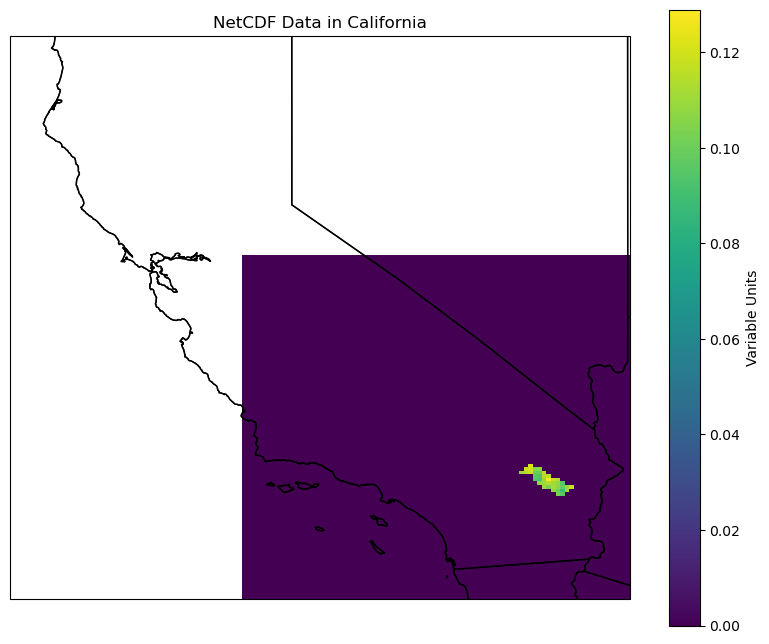

In [9]:
data = biomass

# Create a map using the PlateCarree projection centered on California.
projection = ccrs.PlateCarree(central_longitude=-120)

# Create a figure and axis for the map.
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(10, 8))

# Plot the data on the map.
data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Variable Units'})

# Add coastlines and state boundaries to the map.
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)

# Set the map extent to California.
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Set a title for the plot.
plt.title('NetCDF Data in California')

# Show the plot.
plt.show()

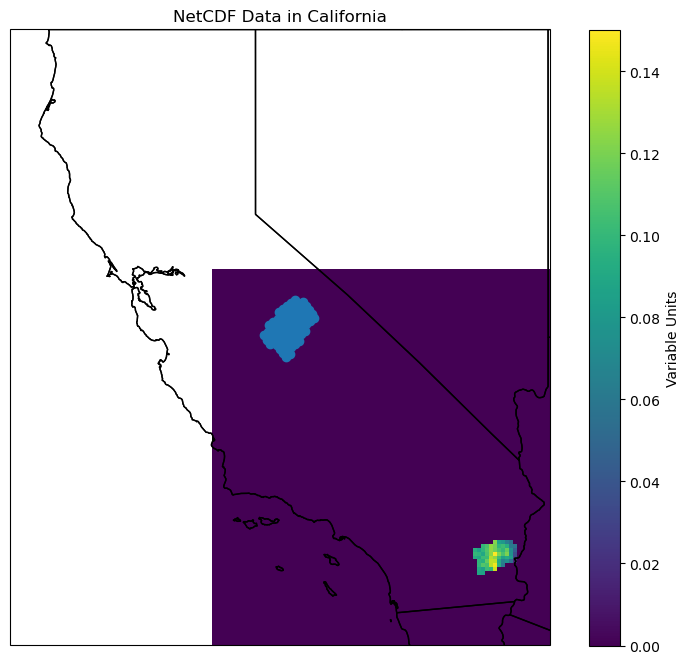

In [48]:
data = biomass_ahb

# Create a map using the PlateCarree projection centered on California.
projection = ccrs.PlateCarree(central_longitude=-120)

# Create a figure and axis for the map.
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(10, 8))

# Plot the data on the map.
data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Variable Units'})

mask_gdf_biomass.plot(ax = ax, transform=ccrs.PlateCarree())

# Add coastlines and state boundaries to the map.
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)

# Set the map extent to California.
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Set a title for the plot.
plt.title('NetCDF Data in California')

# Show the plot.
plt.show()

In [18]:
data

<xarray.DataArray 'FATES_VEGC_PF' (time: 1, lat: 151, lon: 147)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) object 1961-01-01 00:00:00
  * lon      (lon) float32 -120.9 -120.8 -120.7 -120.6 ... -109.2 -109.1 -109.0
  * lat      (lat) float32 28.62 28.68 28.75 28.81 ... 37.9 37.96 38.02 38.08